# Evaluation vorticity GCMx -> 2.2km-4x over Birmingham
With correct grid for GCMx vorticity so it matches 60km vort grid

64x64 pixel target

Includes learnt feature map with 8 channels

## Diff model

Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [12]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, open_samples_ds, show_samples, distribution_figure

In [13]:
split = "val"
dataset_name = "2.2km-coarsened-gcm-2.2km-coarsened-4x_birmingham_vorticity850_random"
gcm_derived_dataset_name = "60km-2.2km-coarsened-4x_birmingham_vorticity850_random"

run_name = "gcmx-4x_bham_vorticity850_random-learnt-map-8"
checkpoint_id = 20

In [17]:
cpm_derived_samples_ds = open_samples_ds(run_name, checkpoint_id, dataset_name, split).isel(sample_id=slice(3))
cpm_eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc"))

cpm_ds = xr.merge([cpm_derived_samples_ds, cpm_eval_ds], join="inner")

gcm_derived_samples_ds = open_samples_ds(run_name, checkpoint_id, gcm_derived_dataset_name, split)
gcm_eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", gcm_derived_dataset_name, f"{split}.nc"))

gcm_ds = xr.merge([gcm_derived_samples_ds, gcm_eval_ds], join="inner")

merged_ds = xr.concat([cpm_ds, gcm_ds], pd.Index(["CPM", "GCM"], name='source'))

# convert from kg m-2 s-1 (i.e. mm s-1) to mm day-1
merged_ds["pred_pr"] = (merged_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
merged_ds["target_pr"] = (merged_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

merged_ds

<xarray.Dataset>
Dimensions:                     (time: 10, sample_id: 3, model: 1, source: 2,
                                 bnds: 2, grid_latitude: 64, grid_longitude: 64)
Coordinates:
    pressure                    (time) float32 850.0 850.0 850.0 ... 850.0 850.0
  * sample_id                   (sample_id) int64 1 2 0
  * model                       (model) <U45 'gcmx-4x_bham_vorticity850_rando...
  * time                        (time) object 1980-12-03 12:00:00 ... 1981-02...
    season                      (time) int64 0 0 0 0 0 0 0 0 0 0
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * source                      (source) object 'CPM' 'GCM'
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (source, model, sample_id, time) float64 -2.1...
    time_bnds                   (source, model, sample_id, time, bnds) object ...
    grid_latitude_bnds          (source, model, sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (source, model, sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (source, model, sample_id, time, grid_latitude, grid_longitude) float32 ...
    target_pr                   (source, time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (source, time, grid_latitude, grid_longitude) float64 ...

In [18]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"].sel(source="CPM")

total_pred_pr = merged_ds["pred_pr"].mean(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sel(source="CPM").mean(dim=["grid_longitude", "grid_latitude"])

## Samples

In [19]:
sorted_time = total_target_pr.sortby(total_target_pr)["time"].values

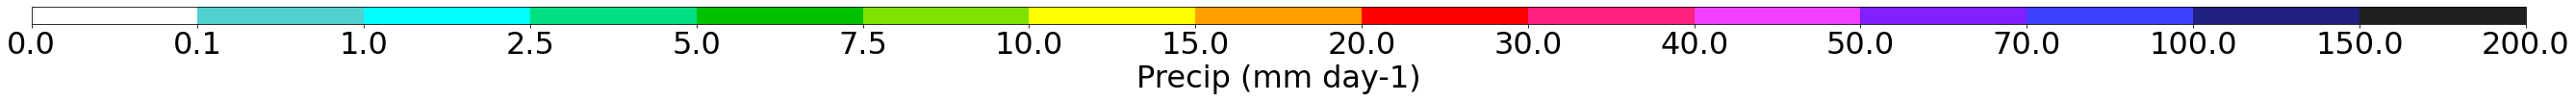

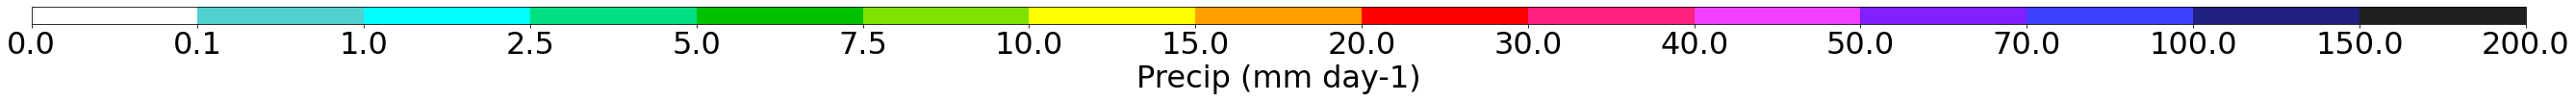

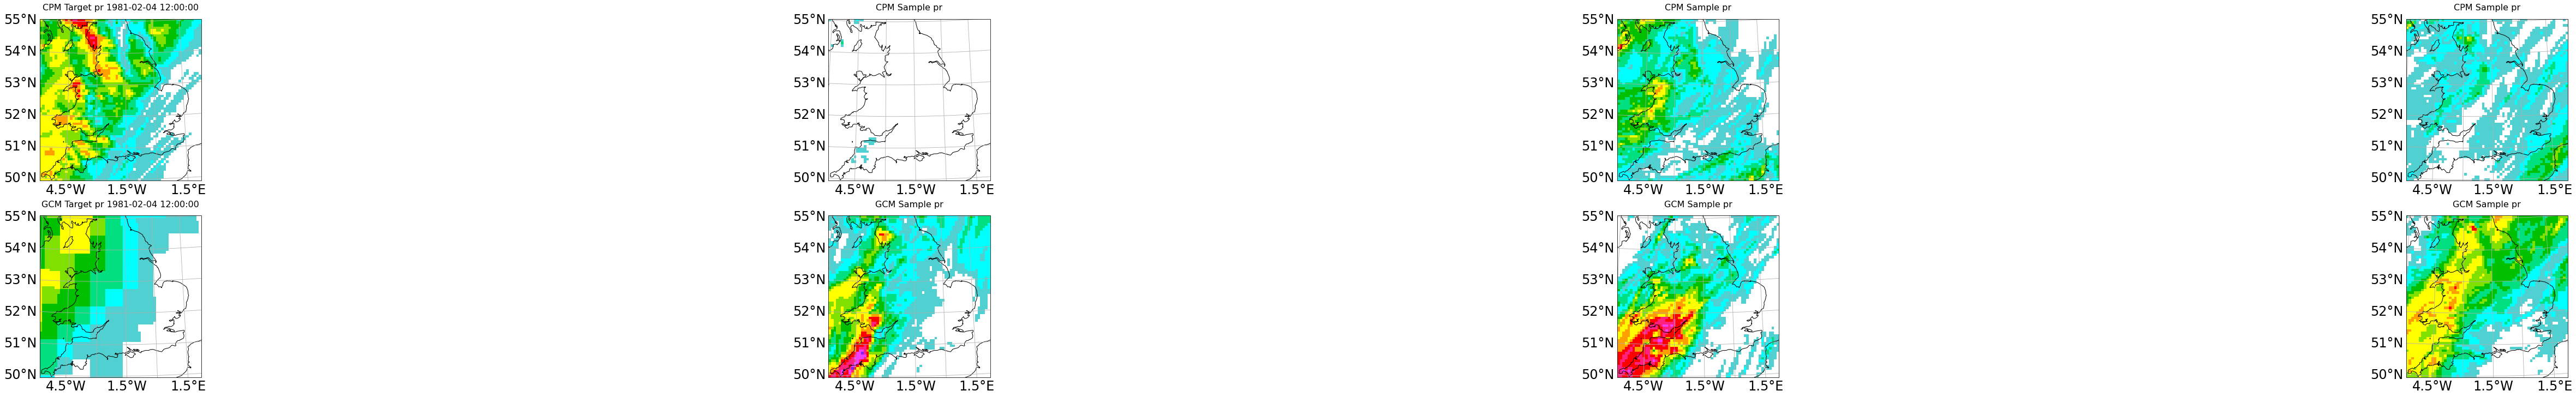

In [26]:
timestamp_chunks = [
    sorted_time[t:t+3] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
]
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
vmin = 0.5#1e-1*3600*24
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)


for timestamps in timestamp_chunks:
    for model in merged_ds["model"].values:
        ds = merged_ds.sel(model=model)
        show_samples(ds, timestamps, vmin, vmax)

## Frequency distribution

### Pixel

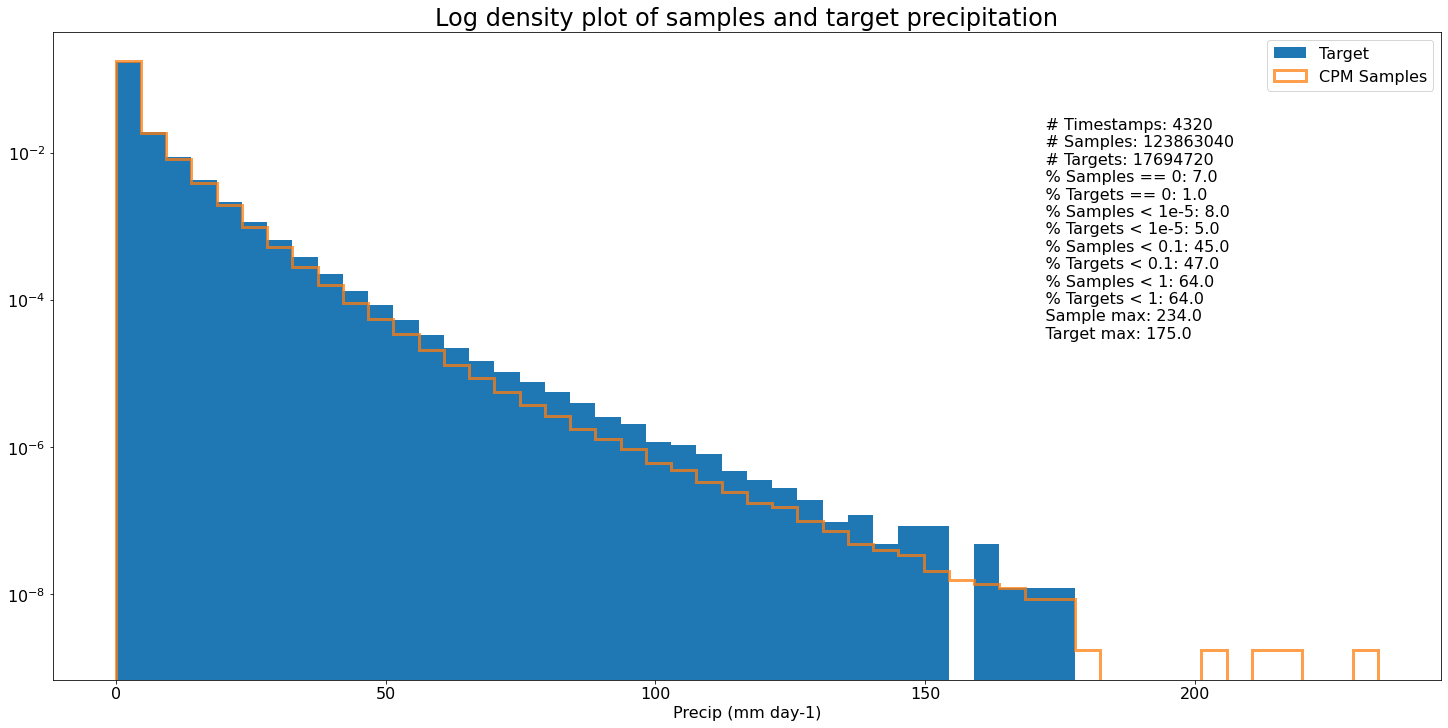

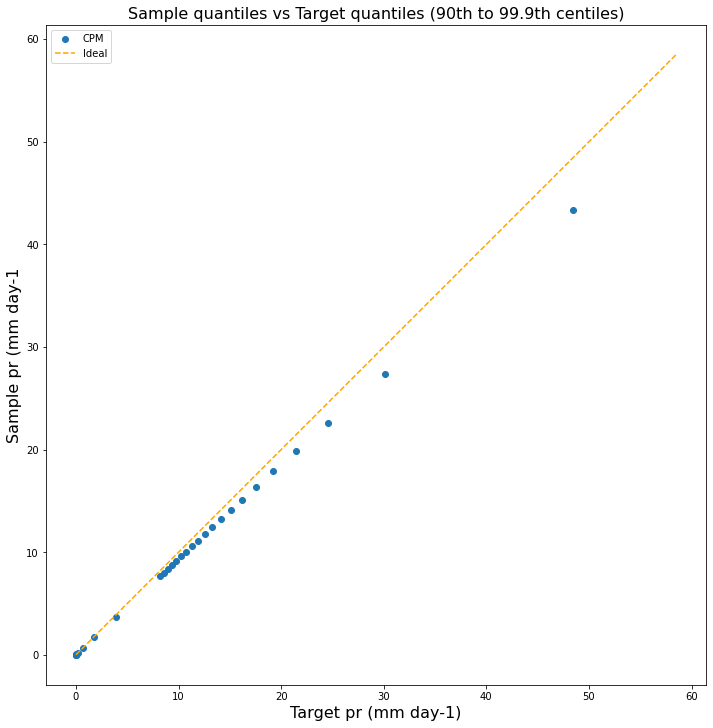

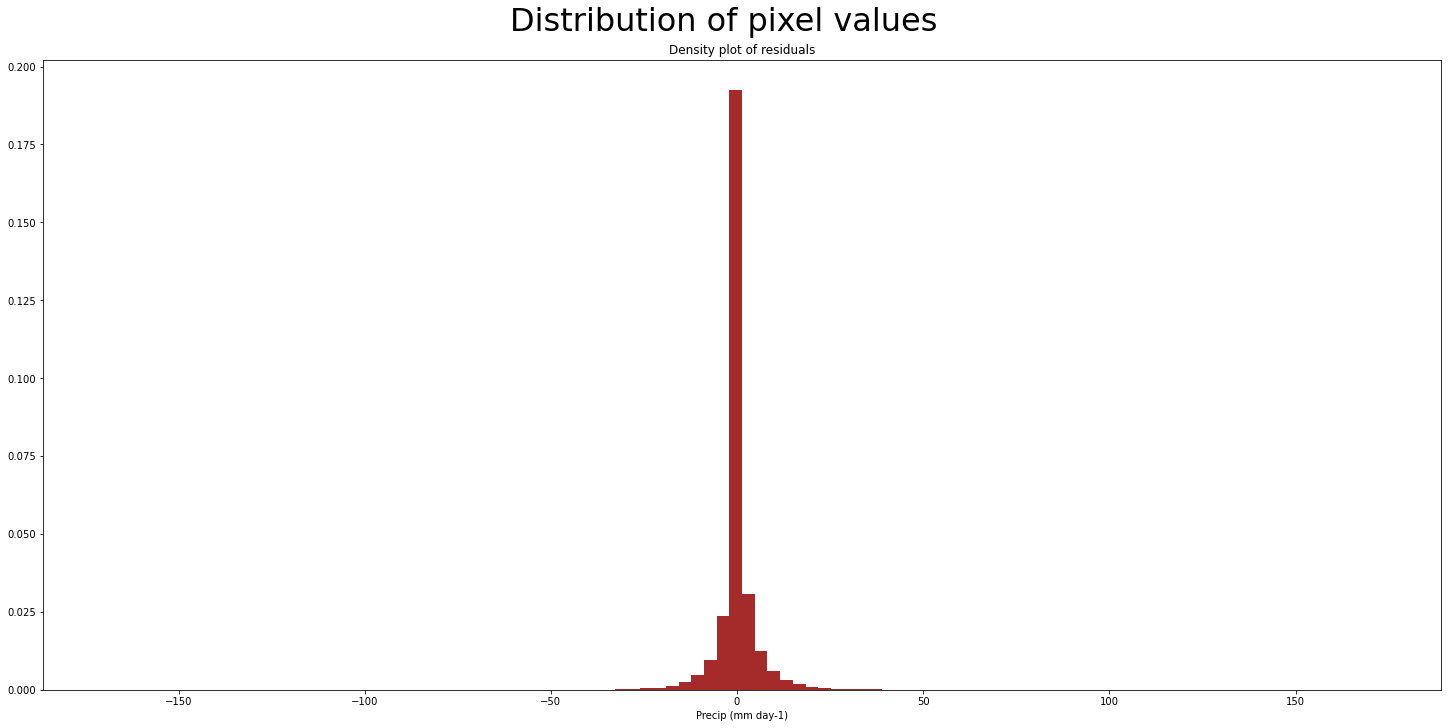

In [7]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.999,20)])

distribution_figure(target_pr, pred_pr, quantiles, 80, 100, "Distribution of pixel values")

### Mean over space

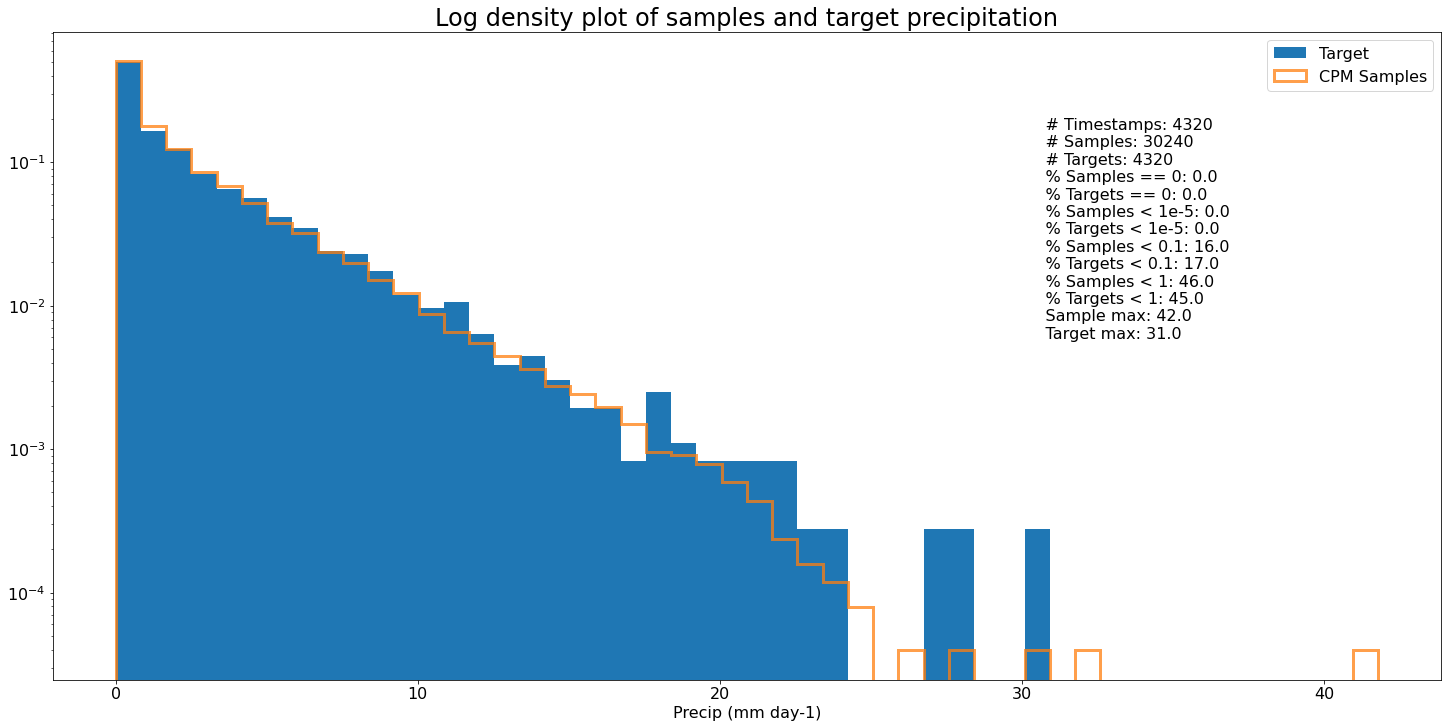

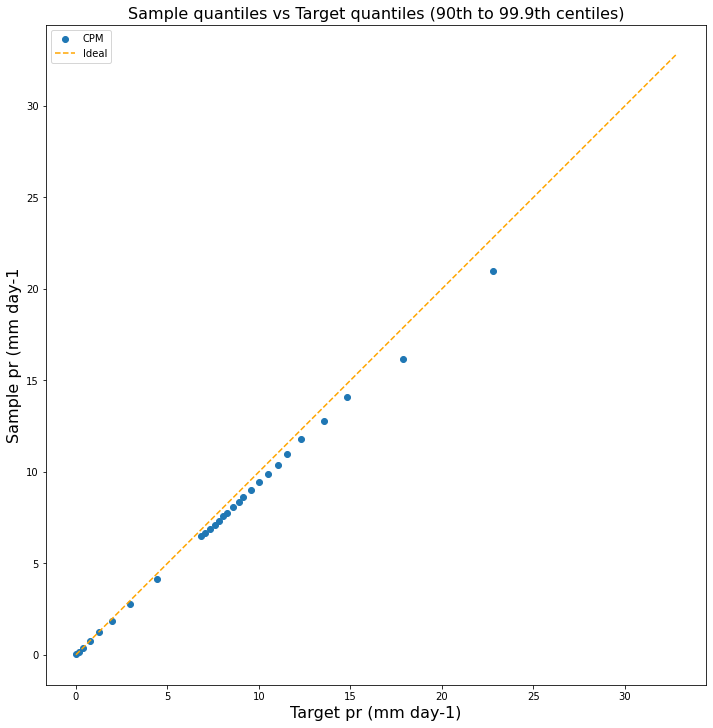

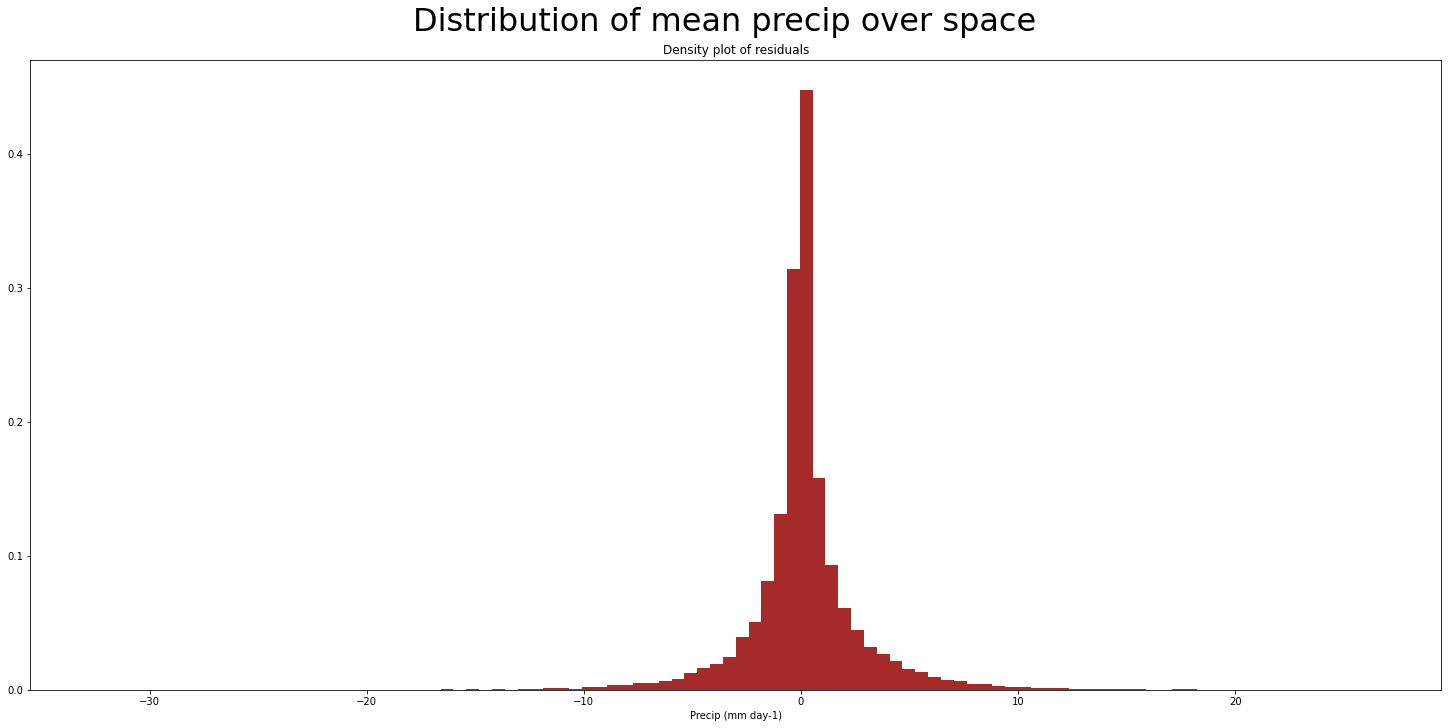

In [8]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.999,20)])

distribution_figure(total_target_pr, total_pred_pr, quantiles, 1e4, 2e4, "Distribution of mean precip over space")

## Means

CPM

gcmx-4x_bham_vorticity850_random-learnt-map-8

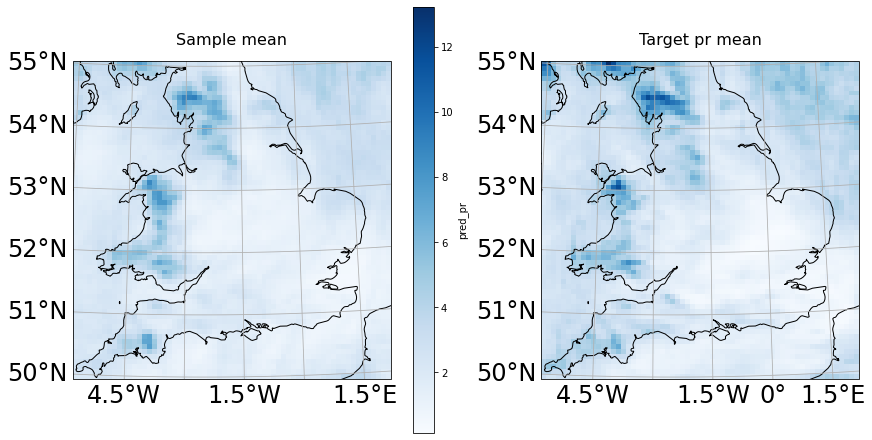

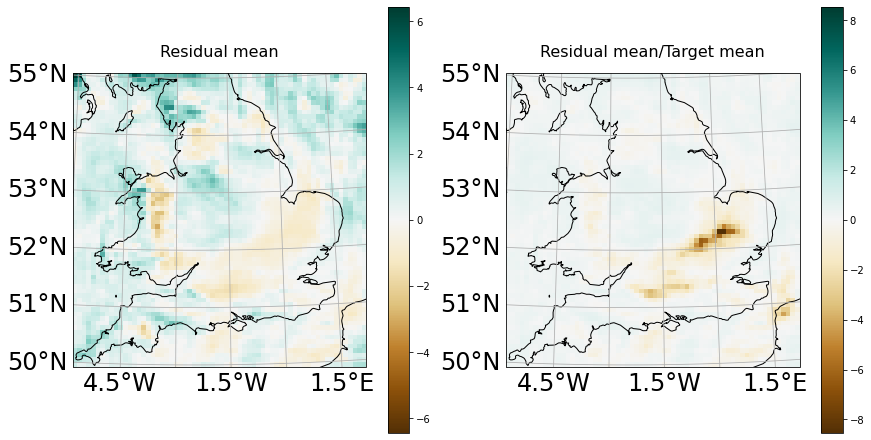

GCM

gcmx-4x_bham_vorticity850_random-learnt-map-8

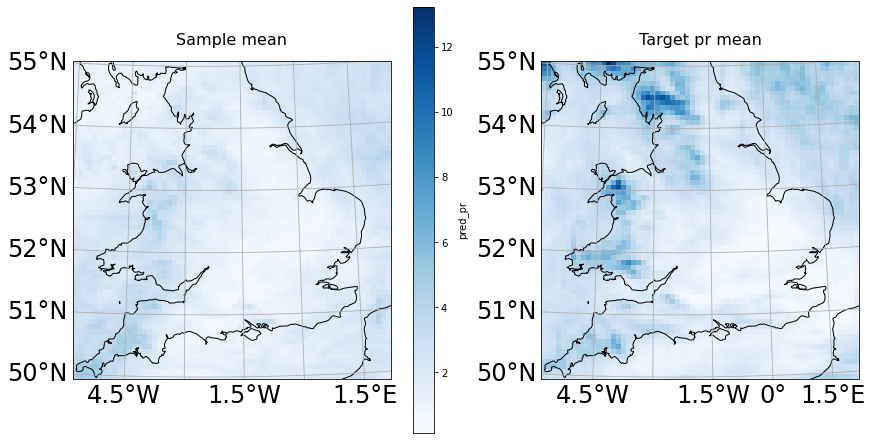

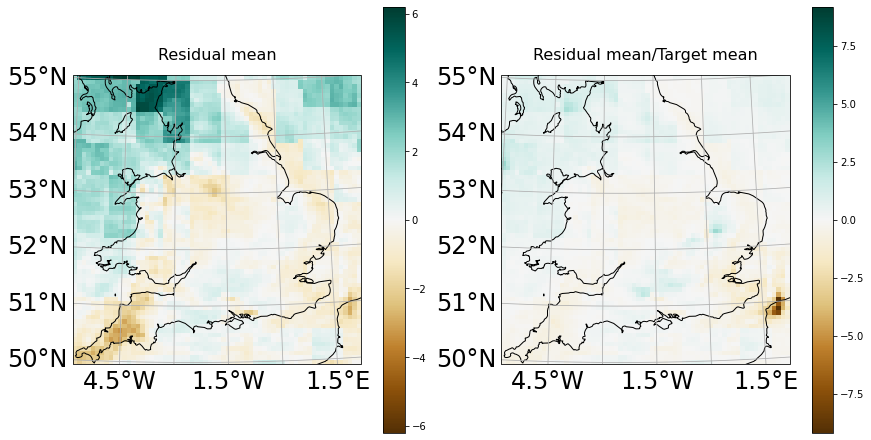

In [28]:
target_mean = merged_ds['target_pr'].sel(source="CPM").mean(dim="time")
sample_mean = merged_ds['pred_pr'].mean(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [sample_mean, target_mean]])
vmax = max([da.max().values for da in [sample_mean, target_mean]])

residuals = merged_ds['target_pr'] - merged_ds['pred_pr']

for source in sample_mean["source"].values:
    mean_ds = sample_mean.sel(source = source)
    residuals_ds = residuals.sel(source = source)
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    for model in mean_ds["model"].values:
        IPython.display.display_html(f"<h2>{model}</h2>", raw=True)
        mean_ds = mean_ds.sel(model = model)
        residuals_ds = residuals_ds.sel(model = model)
        
        residual_mean = residuals_ds.mean(dim=["sample_id", "time"])
        
        fig, axd = plt.subplot_mosaic([["Sample", "Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

        ax = axd["Sample"]
        plot_grid(mean_ds, ax, title="Sample mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

        ax = axd["Target"]
        plot_grid(target_mean, ax, title="Target pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=False)

        plt.show()

        fig, axd = plt.subplot_mosaic([["Residual", "Ratio"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

        ax = axd["Residual"]
        plot_grid(residual_mean, ax, title="Residual mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

        ax = axd["Ratio"]
        plot_grid((residual_mean/target_mean), ax, title="Residual mean/Target mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

        plt.show()


## Standard deviation

CPM

gcmx-4x_bham_vorticity850_random-learnt-map-8

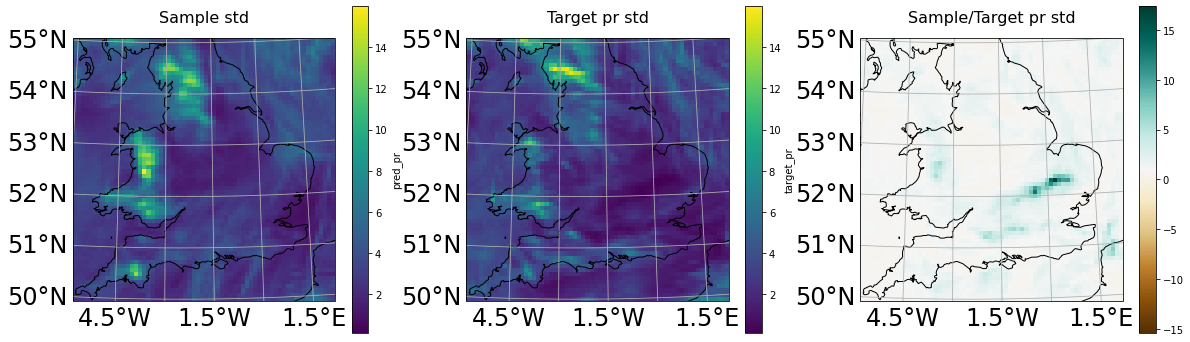

GCM

gcmx-4x_bham_vorticity850_random-learnt-map-8

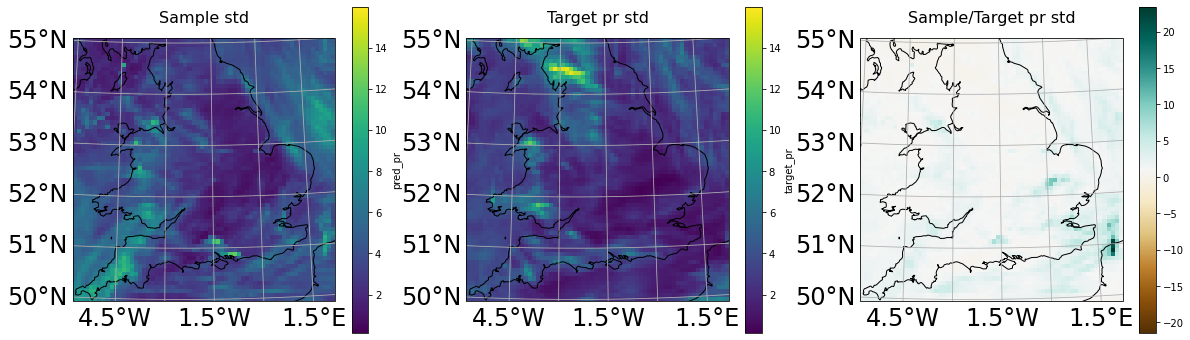

In [29]:
target_std = merged_ds['target_pr'].sel(source="CPM").std(dim="time")
sample_std = merged_ds['pred_pr'].std(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [sample_std, target_std]])
vmax = max([da.max().values for da in [sample_std, target_std]])

for source in sample_std["source"].values:
    std_ds = sample_std.sel(source = source)
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    for model in std_ds["model"].values:
        std_ds = std_ds.sel(model = model)
        IPython.display.display_html(f"<h2>{model}</h2>", raw=True)
        
        fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection=cp_model_rotated_pole))

        ax = axs[0]
        plot_grid(std_ds, ax, title="Sample std", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True, cmap="viridis")

        ax = axs[1]
        plot_grid(target_std, ax, title="Target pr std", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True, cmap="viridis")

        ax = axs[2]
        plot_grid((std_ds/target_std), ax, title="Sample/Target pr std", norm=None, cmap="BrBG", center=1, add_colorbar=True)

        plt.show()

## Scatter

In [11]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [12]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [13]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

## Correlation